# Proyecto 2 Analisis Exploratorio

In [1]:
import os
import pandas as pd
import pydicom
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE


Contenido de la carpeta principal:
['sample_submission.csv', 'train_images', 'train_bounding_boxes.csv', 'segmentations', 'train.csv', 'test.csv', 'test_images']
------------------------------------------------------------
Archivos CSV encontrados:
['sample_submission.csv', 'train_bounding_boxes.csv', 'train.csv', 'test.csv']
------------------------------------------------------------
Carpetas de imágenes encontradas:
['train_images', 'test_images']
------------------------------------------------------------
Ejemplos de estudios en train_images:
['1.2.826.0.1.3680043.17625', '1.2.826.0.1.3680043.3850', '1.2.826.0.1.3680043.2286', '1.2.826.0.1.3680043.14435', '1.2.826.0.1.3680043.3442']

Estudio seleccionado: 1.2.826.0.1.3680043.2286
Número de imágenes DICOM en este estudio: 333
Ejemplos de archivos DICOM: ['257.dcm', '240.dcm', '317.dcm', '12.dcm', '323.dcm']


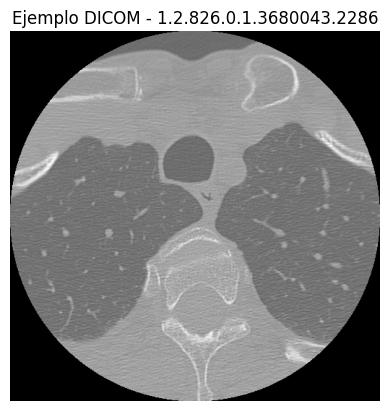

In [3]:
import os
import random
import pydicom
import matplotlib.pyplot as plt

# Ruta del dataset
data_path = "/kaggle/input/rsna-2022-cervical-spine-fracture-detection"

# Ver qué carpetas/archivos hay dentro del dataset principal
print("Contenido de la carpeta principal:")
print(os.listdir(data_path))
print("-" * 60)

# Mostrar los primeros archivos CSV si existen
csv_files = [f for f in os.listdir(data_path) if f.endswith(".csv")]
print("Archivos CSV encontrados:")
print(csv_files)
print("-" * 60)

# Ver si existen carpetas de imágenes
img_folders = [f for f in os.listdir(data_path) if "image" in f]
print("Carpetas de imágenes encontradas:")
print(img_folders)
print("-" * 60)

# Listar algunos estudios dentro de 'train_images'
train_img_path = os.path.join(data_path, "train_images")
if os.path.exists(train_img_path):
    sample_studies = os.listdir(train_img_path)[:5]
    print("Ejemplos de estudios en train_images:")
    print(sample_studies)
    
    # Elegir uno y mostrar algunas imágenes DICOM
    study_id = random.choice(sample_studies)
    study_path = os.path.join(train_img_path, study_id)
    dicoms = [f for f in os.listdir(study_path) if f.endswith(".dcm")]
    print(f"\nEstudio seleccionado: {study_id}")
    print(f"Número de imágenes DICOM en este estudio: {len(dicoms)}")
    print("Ejemplos de archivos DICOM:", dicoms[:5])

    # Mostrar una imagen DICOM aleatoria
    if dicoms:
        sample_file = os.path.join(study_path, random.choice(dicoms))
        ds = pydicom.dcmread(sample_file)
        plt.imshow(ds.pixel_array, cmap="gray")
        plt.title(f"Ejemplo DICOM - {study_id}")
        plt.axis("off")
        plt.show()
else:
    print("No se encontró la carpeta 'train_images'. ¿Agregaste correctamente el dataset?")


In [4]:
import os
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from collections import Counter

# ============================================================================
# EXPLORACIÓN DEL DATASET RSNA 2022 - CERVICAL SPINE FRACTURE
# ============================================================================

data_path = "/kaggle/input/rsna-2022-cervical-spine-fracture-detection"

print("=" * 80)
print("EXPLORACIÓN DEL DATASET")
print("=" * 80)

# 1. CARGAR DATOS
print("\n1️⃣ CARGANDO ARCHIVOS CSV...")
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
bbox_df = pd.read_csv(os.path.join(data_path, "train_bounding_boxes.csv"))

print(f"✓ train.csv: {train_df.shape}")
print(f"✓ train_bounding_boxes.csv: {bbox_df.shape}")

# 2. ANALIZAR train.csv
print("\n" + "=" * 80)
print("2️⃣ ANÁLISIS DE train.csv")
print("=" * 80)

print("\nPrimeras filas:")
print(train_df.head())

print("\nColumnas disponibles:")
print(train_df.columns.tolist())

# Identificar columnas de fracturas
fracture_cols = [col for col in train_df.columns if '_fracture' in col]
print(f"\nColumnas de fracturas vertebrales: {fracture_cols}")

# Contar fracturas por vértebra
print("\n📊 DISTRIBUCIÓN DE FRACTURAS POR VÉRTEBRA:")
for col in fracture_cols:
    num_fracturas = train_df[col].sum()
    porcentaje = (num_fracturas / len(train_df)) * 100
    print(f"   {col}: {num_fracturas} ({porcentaje:.2f}%)")

# Contar estudios con al menos una fractura
estudios_con_fracturas = train_df[fracture_cols].sum(axis=1) > 0
num_estudios_con_fracturas = estudios_con_fracturas.sum()
print(f"\n✓ Estudios con al menos 1 fractura: {num_estudios_con_fracturas} / {len(train_df)}")
print(f"  ({(num_estudios_con_fracturas/len(train_df))*100:.2f}%)")

# 3. ANALIZAR train_bounding_boxes.csv
print("\n" + "=" * 80)
print("3️⃣ ANÁLISIS DE train_bounding_boxes.csv")
print("=" * 80)

print("\nPrimeras filas:")
print(bbox_df.head())

print("\nColumnas disponibles:")
print(bbox_df.columns.tolist())

# Contar bounding boxes
print(f"\n📦 Total de bounding boxes: {len(bbox_df)}")
print(f"📦 Estudios únicos con bboxes: {bbox_df['StudyInstanceUID'].nunique()}")

# Ver qué vértebras están anotadas
if 'label' in bbox_df.columns:
    print("\n📍 Vértebras anotadas en bounding boxes:")
    vertebrae_counts = bbox_df['label'].value_counts()
    for vertebra, count in vertebrae_counts.items():
        print(f"   {vertebra}: {count} bboxes")

# 4. CRUCE DE INFORMACIÓN
print("\n" + "=" * 80)
print("4️⃣ CRUCE: FRACTURAS vs BOUNDING BOXES")
print("=" * 80)

# Estudios con fracturas según train.csv
estudios_fracturados_train = set(
    train_df[train_df[fracture_cols].sum(axis=1) > 0]['StudyInstanceUID'].values
)

# Estudios con bounding boxes
estudios_con_bbox = set(bbox_df['StudyInstanceUID'].unique())

# Todos los estudios
todos_los_estudios = set(train_df['StudyInstanceUID'].unique())

print(f"📊 Estudios con fracturas (train.csv): {len(estudios_fracturados_train)}")
print(f"📦 Estudios con bounding boxes: {len(estudios_con_bbox)}")
print(f"🔗 Estudios con AMBOS (fracturas + bbox): {len(estudios_fracturados_train & estudios_con_bbox)}")
print(f"📁 Total de estudios únicos: {len(todos_los_estudios)}")

# Análisis más detallado
estudios_solo_fracturas = estudios_fracturados_train - estudios_con_bbox
estudios_solo_bbox = estudios_con_bbox - estudios_fracturados_train
estudios_ambos = estudios_fracturados_train & estudios_con_bbox

print(f"\n🔍 DESGLOSE:")
print(f"   - Solo fracturas (sin bbox): {len(estudios_solo_fracturas)}")
print(f"   - Solo bbox (sin fracturas): {len(estudios_solo_bbox)}")
print(f"   - Con ambos: {len(estudios_ambos)}")

# 5. ANALIZAR SEGMENTACIONES
print("\n" + "=" * 80)
print("5️⃣ ANÁLISIS DE SEGMENTACIONES")
print("=" * 80)

segmentation_path = os.path.join(data_path, "segmentations")
if os.path.exists(segmentation_path):
    seg_files = os.listdir(segmentation_path)
    print(f"✓ Carpeta 'segmentations' encontrada")
    print(f"📁 Archivos de segmentación: {len(seg_files)}")
    print(f"   Ejemplos: {seg_files[:5]}")
else:
    print("❌ No se encontró carpeta 'segmentations'")

# 6. PROPUESTA DE ESTRATEGIA
print("\n" + "=" * 80)
print("6️⃣ ESTRATEGIAS POSIBLES PARA MASK R-CNN")
print("=" * 80)

print("\n📌 OPCIÓN 1: Usar solo estudios con bounding boxes")
print(f"   - Disponibles: {len(estudios_con_bbox)} estudios")
print(f"   - Ventaja: Anotaciones explícitas de ubicación")
print(f"   - Desventaja: Dataset más pequeño")

print("\n📌 OPCIÓN 2: Usar segmentaciones de vértebras")
print(f"   - Requiere: Procesar archivos de segmentación")
print(f"   - Ventaja: Más datos disponibles")
print(f"   - Desventaja: Requiere procesamiento adicional")

print("\n📌 OPCIÓN 3: Usar nivel de slice (SliceInstanceUID)")
print(f"   - Estrategia: Trabajar con slices individuales de CT")
print(f"   - Ventaja: Usa toda la información 3D")
print(f"   - Desventaja: Mayor complejidad de implementación")

# 7. VERIFICAR ESTRUCTURA DE BOUNDING BOXES
print("\n" + "=" * 80)
print("7️⃣ ESTRUCTURA DE BOUNDING BOXES")
print("=" * 80)

print("\nInformación de columnas en bbox_df:")
print(bbox_df.info())

print("\nEstadísticas de coordenadas:")
if 'x' in bbox_df.columns:
    print(bbox_df[['x', 'y', 'width', 'height']].describe())

# Verificar si hay valores nulos
print("\nValores nulos por columna:")
print(bbox_df.isnull().sum())

# 8. EJEMPLO DE ESTUDIO CON BBOX
print("\n" + "=" * 80)
print("8️⃣ EJEMPLO DE ESTUDIO CON BOUNDING BOXES")
print("=" * 80)

if len(estudios_con_bbox) > 0:
    ejemplo_estudio = list(estudios_con_bbox)[0]
    print(f"\nEstudio seleccionado: {ejemplo_estudio}")
    
    # Información de fracturas
    estudio_info = train_df[train_df['StudyInstanceUID'] == ejemplo_estudio]
    print("\nFracturas en train.csv:")
    for col in fracture_cols:
        valor = estudio_info[col].values[0]
        if valor == 1:
            print(f"   ✓ {col}: FRACTURA")
    
    # Bounding boxes
    estudio_bboxes = bbox_df[bbox_df['StudyInstanceUID'] == ejemplo_estudio]
    print(f"\nBounding boxes disponibles: {len(estudio_bboxes)}")
    print(estudio_bboxes)

print("\n" + "=" * 80)
print("✅ EXPLORACIÓN COMPLETADA")
print("=" * 80)

EXPLORACIÓN DEL DATASET

1️⃣ CARGANDO ARCHIVOS CSV...
✓ train.csv: (2019, 9)
✓ train_bounding_boxes.csv: (7217, 6)

2️⃣ ANÁLISIS DE train.csv

Primeras filas:
            StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0
1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0
2  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0
3  1.2.826.0.1.3680043.12351                0   0   0   0   0   0   0   0
4   1.2.826.0.1.3680043.1363                1   0   0   0   0   1   0   0

Columnas disponibles:
['StudyInstanceUID', 'patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

Columnas de fracturas vertebrales: []

📊 DISTRIBUCIÓN DE FRACTURAS POR VÉRTEBRA:

✓ Estudios con al menos 1 fractura: 0 / 2019
  (0.00%)

3️⃣ ANÁLISIS DE train_bounding_boxes.csv

Primeras filas:
            StudyInstanceUID          x          y     width    height  \
0  1.2.826.0.1.368004

In [12]:
!pip install -U pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg python-gdcm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.5 MB/s eta 0:00:0000:010:01


In [16]:
import os
import sys
import importlib

# 🔧 1. Añade la ruta de las librerías GDCM al entorno
os.environ["LD_LIBRARY_PATH"] = "/usr/local/lib/python3.11/dist-packages/gdcm/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

# 🔧 2. Fuerza recarga de módulos por si pydicom ya fue importado
if "pydicom" in sys.modules:
    del sys.modules["pydicom"]

import pydicom
importlib.import_module("pydicom.pixel_data_handlers.gdcm_handler")
importlib.import_module("pydicom.pixel_data_handlers.pylibjpeg_handler")

print("Handlers disponibles:")
print(f"  - GDCM: {pydicom.pixel_data_handlers.gdcm_handler.is_available()}")
print(f"  - pylibjpeg: {pydicom.pixel_data_handlers.pylibjpeg_handler.is_available()}")


Handlers disponibles:


AttributeError: module 'pydicom' has no attribute 'pixel_data_handlers'

Shape: (512, 512)


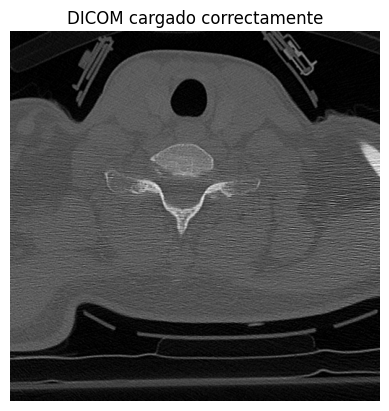

In [24]:
from pydicom import dcmread
import matplotlib.pyplot as plt

ruta = "/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.14435/377.dcm"

ds = dcmread(ruta)
img = ds.pixel_array

print("Shape:", img.shape)
plt.imshow(img, cmap='gray')
plt.title("DICOM cargado correctamente")
plt.axis('off')
plt.show()


In [27]:
import os
import numpy as np
import pandas as pd
import pydicom
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. CONFIGURACIÓN Y PARÁMETROS
# ============================================================================

class Config:
    """Configuración centralizada del proyecto"""
    # Rutas
    DATA_PATH = "/kaggle/input/rsna-2022-cervical-spine-fracture-detection"
    TRAIN_IMG_PATH = os.path.join(DATA_PATH, "train_images")
    TRAIN_CSV = os.path.join(DATA_PATH, "train.csv")
    BBOX_CSV = os.path.join(DATA_PATH, "train_bounding_boxes.csv")
    SEGMENTATION_PATH = os.path.join(DATA_PATH, "segmentations")
    
    # Hiperparámetros
    BATCH_SIZE = 2
    NUM_EPOCHS = 20
    LEARNING_RATE = 0.0005
    NUM_WORKERS = 2
    IMG_SIZE = 512
    
    # Vértebras cervicales
    VERTEBRAE_LABELS = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
    NUM_CLASSES = 3  # background + normal vertebra + fractured vertebra
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Validación
    VAL_SPLIT = 0.2
    RANDOM_STATE = 42

config = Config()

# ============================================================================
# 2. DATASET PERSONALIZADO
# ============================================================================

class CervicalSpineDataset(Dataset):
    """
    Dataset para CT scans de columna cervical con detección de fracturas.
    
    Características:
    - Trabaja con slices individuales de CT
    - Combina bounding boxes con etiquetas de fracturas
    - Crea máscaras sintéticas a partir de bounding boxes
    """
    
    def __init__(self, study_ids, train_df, bbox_df, img_path, transforms=None):
        """
        Args:
            study_ids: Lista de StudyInstanceUIDs a usar
            train_df: DataFrame con etiquetas de fracturas (columnas C1-C7)
            bbox_df: DataFrame con bounding boxes por slice
            img_path: Ruta a las imágenes DICOM
            transforms: Transformaciones de Albumentations
        """
        self.study_ids = study_ids
        self.train_df = train_df
        self.bbox_df = bbox_df
        self.img_path = img_path
        self.transforms = transforms
        
        # Crear índice de slices con bboxes
        self.samples = self._build_sample_index()
        
    def _build_sample_index(self):
        """Construye índice de (study_id, slice_number) que tienen bboxes"""
        samples = []
        
        for study_id in self.study_ids:
            # Obtener bboxes para este estudio
            study_bboxes = self.bbox_df[self.bbox_df['StudyInstanceUID'] == study_id]
            
            if len(study_bboxes) == 0:
                continue
            
            # Obtener slices únicos con bboxes
            slice_numbers = study_bboxes['slice_number'].unique()
            
            for slice_num in slice_numbers:
                samples.append({
                    'study_id': study_id,
                    'slice_number': slice_num
                })
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def _get_fracture_labels(self, study_id):
        """Obtiene etiquetas de fracturas para un estudio"""
        study_row = self.train_df[self.train_df['StudyInstanceUID'] == study_id]
        
        if len(study_row) == 0:
            return {vertebra: 0 for vertebra in config.VERTEBRAE_LABELS}
        
        fractures = {}
        for vertebra in config.VERTEBRAE_LABELS:
            fractures[vertebra] = study_row[vertebra].values[0]
        
        return fractures
    
    def _load_dicom_slice(self, study_id, slice_number):
        """Carga un slice específico del estudio con soporte para JPEG Lossless"""
        study_path = os.path.join(self.img_path, study_id)
        
        if not os.path.exists(study_path):
            return None
        
        # Buscar el archivo DICOM correspondiente al slice
        dicom_file = f"{int(slice_number)}.dcm"
        dicom_path = os.path.join(study_path, dicom_file)
        
        if not os.path.exists(dicom_path):
            # Intentar encontrar cualquier archivo cercano
            all_files = sorted([f for f in os.listdir(study_path) if f.endswith('.dcm')])
            if not all_files:
                return None
            # Usar el slice más cercano disponible
            slice_nums = [int(f.replace('.dcm', '')) for f in all_files]
            closest_idx = np.argmin([abs(s - slice_number) for s in slice_nums])
            dicom_path = os.path.join(study_path, all_files[closest_idx])
        
        try:
            # Leer DICOM con soporte para compresión
            ds = pydicom.dcmread(dicom_path)
            
            # Intentar obtener pixel_array
            try:
                img = ds.pixel_array.astype(np.float32)
            except Exception as e:
                # Si falla la descompresión, intentar con force=True
                import pydicom.pixel_data_handlers.gdcm_handler as gdcm_handler
                import pydicom.pixel_data_handlers.pylibjpeg_handler as pylibjpeg_handler
                
                # Registrar handlers si no están registrados
                if not pydicom.pixel_data_handlers.gdcm_handler.is_available():
                    pydicom.pixel_data_handlers.gdcm_handler.setup()
                if not pydicom.pixel_data_handlers.pylibjpeg_handler.is_available():
                    pydicom.pixel_data_handlers.pylibjpeg_handler.setup()
                
                img = ds.pixel_array.astype(np.float32)
            
            # Aplicar rescale si está disponible
            if hasattr(ds, 'RescaleIntercept') and hasattr(ds, 'RescaleSlope'):
                img = img * ds.RescaleSlope + ds.RescaleIntercept
            
            # Normalizar con window para hueso
            img = np.clip(img, -1000, 2000)
            img = (img - img.min()) / (img.max() - img.min() + 1e-6) * 255
            img = img.astype(np.uint8)
            
            # Convertir a RGB
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            
            return img
            
        except Exception as e:
            # Silenciar errores después del primer aviso
            if not hasattr(self, '_compression_warning_shown'):
                print(f"⚠️  Algunos archivos DICOM no se pueden leer (compresión JPEG Lossless)")
                print(f"   Instala: pip install pylibjpeg pylibjpeg-libjpeg python-gdcm")
                self._compression_warning_shown = True
            return None
    
    def _get_bboxes_for_slice(self, study_id, slice_number):
        """Obtiene bounding boxes para un slice específico"""
        slice_bboxes = self.bbox_df[
            (self.bbox_df['StudyInstanceUID'] == study_id) &
            (self.bbox_df['slice_number'] == slice_number)
        ]
        
        boxes = []
        labels = []
        
        # Obtener información de fracturas del estudio
        fractures = self._get_fracture_labels(study_id)
        has_any_fracture = any(fractures.values())
        
        for _, row in slice_bboxes.iterrows():
            x, y, w, h = row['x'], row['y'], row['width'], row['height']
            
            # Validar bbox
            if w <= 0 or h <= 0:
                continue
            
            boxes.append([x, y, x + w, y + h])
            
            # Clase: si el estudio tiene fracturas, marcar como fracturada
            # En un caso real, necesitarías mapear bbox -> vértebra específica
            if has_any_fracture:
                labels.append(2)  # Vértebra fracturada
            else:
                labels.append(1)  # Vértebra normal
        
        return np.array(boxes, dtype=np.float32), np.array(labels, dtype=np.int64)
    
    def _create_masks(self, boxes, img_shape):
        """Crea máscaras binarias a partir de bounding boxes"""
        masks = []
        
        for box in boxes:
            mask = np.zeros(img_shape[:2], dtype=np.uint8)
            x_min, y_min, x_max, y_max = box.astype(int)
            
            # Clamp coordinates
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(img_shape[1], x_max)
            y_max = min(img_shape[0], y_max)
            
            # Crear máscara rectangular (en producción, usarías segmentaciones reales)
            mask[y_min:y_max, x_min:x_max] = 1
            masks.append(mask)
        
        return np.array(masks, dtype=np.uint8)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        study_id = sample['study_id']
        slice_number = sample['slice_number']
        
        # Cargar imagen
        img = self._load_dicom_slice(study_id, slice_number)
        
        if img is None:
            # Si falla, retornar el siguiente
            return self.__getitem__((idx + 1) % len(self))
        
        # Obtener bounding boxes
        boxes, labels = self._get_bboxes_for_slice(study_id, slice_number)
        
        if len(boxes) == 0:
            # Si no hay boxes válidos, retornar el siguiente
            return self.__getitem__((idx + 1) % len(self))
        
        # Crear máscaras
        masks = self._create_masks(boxes, img.shape)
        
        # Aplicar transformaciones
        if self.transforms:
            try:
                transformed = self.transforms(
                    image=img,
                    masks=list(masks),
                    bboxes=boxes.tolist(),
                    labels=labels.tolist()
                )
                img = transformed['image']
                masks = transformed['masks']
                boxes = transformed['bboxes']
                labels = transformed['labels']
            except Exception as e:
                print(f"Transform error: {e}")
                return self.__getitem__((idx + 1) % len(self))
        
        # Validar que haya datos después de transformaciones
        if len(boxes) == 0:
            return self.__getitem__((idx + 1) % len(self))
        
        # Convertir a tensores
        if not isinstance(img, torch.Tensor):
            img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        
        # Calcular áreas
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # Crear target
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }
        
        return img, target

# ============================================================================
# 3. TRANSFORMACIONES DE DATOS
# ============================================================================

def get_train_transforms():
    """Transformaciones para entrenamiento"""
    return A.Compose([
        A.Resize(config.IMG_SIZE, config.IMG_SIZE),
        A.HorizontalFlip(p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.3),
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['labels'],
        min_area=100,
        min_visibility=0.3
    ))

def get_valid_transforms():
    """Transformaciones para validación"""
    return A.Compose([
        A.Resize(config.IMG_SIZE, config.IMG_SIZE),
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['labels']
    ))

# ============================================================================
# 4. MODELO MASK R-CNN
# ============================================================================

def get_model_maskrcnn(num_classes=3, pretrained=True):
    """
    Construye Mask R-CNN con ResNet50-FPN
    
    Arquitectura completa:
    1. Backbone: ResNet50 + FPN para extracción de features multi-escala
    2. RPN: Propone regiones candidatas
    3. ROI Align: Alineación precisa de características
    4. Box Head: Clasifica y refina bounding boxes
    5. Mask Head: Genera máscaras de segmentación píxel a píxel
    """
    model = maskrcnn_resnet50_fpn_v2(pretrained=pretrained)
    
    # Reemplazar box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Reemplazar mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )
    
    return model

# ============================================================================
# 5. UTILIDADES
# ============================================================================

def collate_fn(batch):
    """Función para agrupar datos del DataLoader"""
    return tuple(zip(*batch))

# ============================================================================
# 6. ENTRENAMIENTO
# ============================================================================

class Trainer:
    """Entrenador para Mask R-CNN"""
    
    def __init__(self, model, optimizer, device):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.val_losses = []
    
    def train_one_epoch(self, dataloader, epoch):
        """Entrena una época"""
        self.model.train()
        epoch_loss = 0
        num_batches = 0
        
        for batch_idx, (images, targets) in enumerate(dataloader):
            try:
                images = [img.to(self.device) for img in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                self.optimizer.zero_grad()
                losses.backward()
                self.optimizer.step()
                
                epoch_loss += losses.item()
                num_batches += 1
                
                if batch_idx % 20 == 0:
                    print(f"  Batch {batch_idx}/{len(dataloader)}, Loss: {losses.item():.4f}")
            
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue
        
        if num_batches == 0:
            return 0
        
        avg_loss = epoch_loss / num_batches
        self.train_losses.append(avg_loss)
        return avg_loss
    
    @torch.no_grad()
    def validate(self, dataloader):
        """Valida el modelo"""
        self.model.train()
        epoch_loss = 0
        num_batches = 0
        
        for images, targets in dataloader:
            try:
                images = [img.to(self.device) for img in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                epoch_loss += losses.item()
                num_batches += 1
            
            except Exception as e:
                continue
        
        if num_batches == 0:
            return 0
        
        avg_loss = epoch_loss / num_batches
        self.val_losses.append(avg_loss)
        return avg_loss
    
    def fit(self, train_loader, val_loader, num_epochs):
        """Entrena el modelo"""
        best_val_loss = float('inf')
        
        for epoch in range(num_epochs):
            print(f"\n{'='*60}")
            print(f"Epoch {epoch+1}/{num_epochs}")
            print('='*60)
            
            train_loss = self.train_one_epoch(train_loader, epoch)
            print(f"✓ Training Loss: {train_loss:.4f}")
            
            val_loss = self.validate(val_loader)
            print(f"✓ Validation Loss: {val_loss:.4f}")
            
            if val_loss < best_val_loss and val_loss > 0:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_mask_rcnn.pth')
                print(f"⭐ Mejor modelo guardado (val_loss: {val_loss:.4f})")
        
        return self.train_losses, self.val_losses

# ============================================================================
# 7. VISUALIZACIÓN
# ============================================================================

def visualize_predictions(model, dataset, device, num_samples=3):
    """Visualiza predicciones del modelo"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(14, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    for idx, ax_row in zip(indices, axes):
        img, target = dataset[idx]
        
        with torch.no_grad():
            prediction = model([img.to(device)])[0]
        
        img_np = img.permute(1, 2, 0).cpu().numpy()
        
        # Ground truth
        ax_row[0].imshow(img_np)
        ax_row[0].set_title("Ground Truth", fontsize=12, fontweight='bold')
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box.cpu().numpy()
            color = 'red' if label == 2 else 'green'
            rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=2, edgecolor=color, facecolor='none')
            ax_row[0].add_patch(rect)
        ax_row[0].axis('off')
        
        # Predicciones
        ax_row[1].imshow(img_np)
        ax_row[1].set_title("Predictions (score > 0.5)", fontsize=12, fontweight='bold')
        
        scores = prediction['scores'].cpu().numpy()
        boxes = prediction['boxes'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()
        
        for box, score, label in zip(boxes, scores, labels):
            if score > 0.5:
                x1, y1, x2, y2 = box
                color = 'red' if label == 2 else 'blue'
                rect = Rectangle((x1, y1), x2-x1, y2-y1,
                               linewidth=2, edgecolor=color, facecolor='none')
                ax_row[1].add_patch(rect)
                ax_row[1].text(x1, y1-5, f'{score:.2f}', 
                             color=color, fontsize=9, weight='bold',
                             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        ax_row[1].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Predicciones guardadas en 'predictions.png'")

def plot_training_history(train_losses, val_losses):
    """Grafica el historial de entrenamiento"""
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training History - Mask R-CNN', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Historial guardado en 'training_history.png'")



### Configuracion inicial y carga

In [31]:
print("\n" + "="*80)
print("MASK R-CNN - DETECCIÓN DE FRACTURAS CERVICALES")
print("="*80)
print(f"Device: {config.DEVICE}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Learning Rate: {config.LEARNING_RATE}")
print(f"Epochs: {config.NUM_EPOCHS}\n")

# Cargar datos
# Obtener estudios con bboxes
studies_with_bbox = bbox_df['StudyInstanceUID'].unique()
print(f"   ✓ Total estudios: {len(train_df)}")
print(f"   ✓ Estudios con bounding boxes: {len(studies_with_bbox)}")
print(f"   ✓ Total de bounding boxes: {len(bbox_df)}\n")
    


MASK R-CNN - DETECCIÓN DE FRACTURAS CERVICALES
Device: cuda
Batch Size: 2
Learning Rate: 0.0005
Epochs: 20

   ✓ Total estudios: 2019
   ✓ Estudios con bounding boxes: 235
   ✓ Total de bounding boxes: 7217



### Division en entrenamiento y validacion

In [36]:
# Split train/val
train_studies, val_studies = train_test_split(
    studies_with_bbox,
    test_size=config.VAL_SPLIT,
    random_state=config.RANDOM_STATE
)

print(f"📂 Split de datos:")
print(f"   - Training: {len(train_studies)} estudios")
print(f"   - Validation: {len(val_studies)} estudios\n")

# Crear datasets
print("🔄 Creando datasets...")
train_dataset = CervicalSpineDataset(
    train_studies, train_df, bbox_df, 
    config.TRAIN_IMG_PATH, get_train_transforms()
)

val_dataset = CervicalSpineDataset(
    val_studies, train_df, bbox_df,
    config.TRAIN_IMG_PATH, get_valid_transforms()
)

print(f"   ✓ Training samples (slices): {len(train_dataset)}")
print(f"   ✓ Validation samples (slices): {len(val_dataset)}\n")
if len(train_dataset) == 0 or len(val_dataset) == 0:
    print("❌ Error: No hay samples disponibles. Verifica las rutas de datos.")
    
    

📂 Split de datos:
   - Training: 188 estudios
   - Validation: 47 estudios

🔄 Creando datasets...
   ✓ Training samples (slices): 5923
   ✓ Validation samples (slices): 1294



### Cargar datos al modelo

In [39]:
 # DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=config.BATCH_SIZE,
    shuffle=True, num_workers=config.NUM_WORKERS,
    collate_fn=collate_fn, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=config.BATCH_SIZE,
    shuffle=False, num_workers=config.NUM_WORKERS,
    collate_fn=collate_fn, pin_memory=True
)

### Modelo y Optimizador

In [40]:
# Modelo
print("🏗️  Construyendo Mask R-CNN...")
model = get_model_maskrcnn(num_classes=config.NUM_CLASSES, pretrained=True)
model.to(config.DEVICE)
print("   ✓ Modelo cargado (ResNet50-FPN + Mask Head)\n")

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=config.LEARNING_RATE,
    momentum=0.9, weight_decay=0.0005
)


🏗️  Construyendo Mask R-CNN...
   ✓ Modelo cargado (ResNet50-FPN + Mask Head)



### Entrenamiento

In [41]:
# Entrenar
print("🚀 Iniciando entrenamiento...\n")
trainer = Trainer(model, optimizer, config.DEVICE)
train_losses, val_losses = trainer.fit(train_loader, val_loader, config.NUM_EPOCHS)


🚀 Iniciando entrenamiento...


Epoch 1/20
  Batch 0/2962, Loss: 2.0112
  Batch 20/2962, Loss: 0.9703
  Batch 40/2962, Loss: 0.7839
  Batch 60/2962, Loss: 0.8205
  Batch 80/2962, Loss: 0.8668
  Batch 100/2962, Loss: 0.7188
  Batch 120/2962, Loss: 0.6310
  Batch 140/2962, Loss: 0.7207
  Batch 160/2962, Loss: 0.6515
  Batch 180/2962, Loss: 0.6354
  Batch 200/2962, Loss: 0.6712
  Batch 220/2962, Loss: 0.6833
  Batch 240/2962, Loss: 0.6376
  Batch 260/2962, Loss: 0.6028
  Batch 280/2962, Loss: 0.7121
  Batch 300/2962, Loss: 0.7382
  Batch 320/2962, Loss: 0.6886
  Batch 340/2962, Loss: 0.6930
  Batch 360/2962, Loss: 0.7018
  Batch 380/2962, Loss: 0.7339
  Batch 400/2962, Loss: 0.6872
  Batch 420/2962, Loss: 0.6645
  Batch 440/2962, Loss: 0.6204
  Batch 460/2962, Loss: 0.6515
  Batch 480/2962, Loss: 0.7096
  Batch 500/2962, Loss: 0.5642
  Batch 520/2962, Loss: 0.5992
  Batch 540/2962, Loss: 0.6865
  Batch 560/2962, Loss: 0.5409
  Batch 580/2962, Loss: 0.5533
  Batch 600/2962, Loss: 0.5736
  B


📈 Generando visualizaciones...


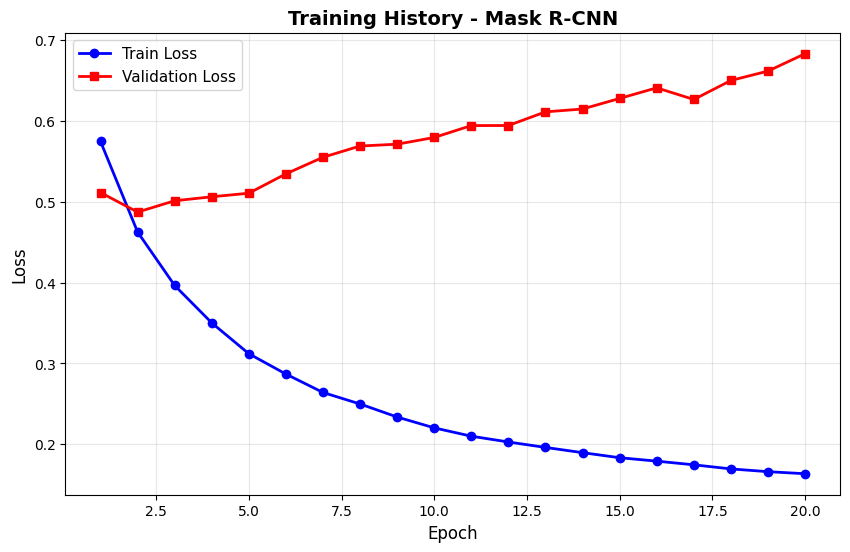

✓ Historial guardado en 'training_history.png'


In [ ]:
# Visualizar
print("\n📈 Generando visualizaciones...")
plot_training_history(train_losses, val_losses)

model.load_state_dict(torch.load('best_mask_rcnn.pth'))
visualize_predictions(model, val_dataset, config.DEVICE, num_samples=3)

print("\n" + "="*80)
print("✅ ENTRENAMIENTO COMPLETADO")
print("="*80)
print("Archivos generados:")
print("  - best_mask_rcnn.pth (modelo entrenado)")
print("  - training_history.png (curvas de aprendizaje)")
print("  - predictions.png (visualización de resultados)")
print("="*80 + "\n")



EVALUACIÓN EN TEST SET - MASK R-CNN
Modelo: best_mask_rcnn.pth
Device: cuda

📊 Cargando datos de test...
   ✓ Test studies: 47
   ✓ Test samples: 1294

🏗️  Cargando modelo...
   ✓ Modelo cargado desde 'best_mask_rcnn.pth'

EVALUANDO MODELO EN TEST SET
IoU Threshold: 0.5
Score Threshold: 0.5



Evaluating: 100%|██████████| 647/647 [02:09<00:00,  5.01it/s]



MÉTRICAS DE EVALUACIÓN

📊 ACCURACY GLOBAL: 0.4134 (41.34%)

--------------------------------------------------------------------------------
MÉTRICAS POR CLASE
--------------------------------------------------------------------------------
             Class  Precision   Recall  F1-Score  Support
        Background        0.0 0.000000  0.000000        0
   Normal Vertebra        0.0 0.000000  0.000000        0
Fractured Vertebra        1.0 0.413447  0.585019     1294

--------------------------------------------------------------------------------
CLASSIFICATION REPORT
--------------------------------------------------------------------------------
                    precision    recall  f1-score   support

        Background       0.00      0.00      0.00         0
   Normal Vertebra       0.00      0.00      0.00         0
Fractured Vertebra       1.00      0.41      0.59      1294

         micro avg       0.41      0.41      0.41      1294
         macro avg       0.33      0.14

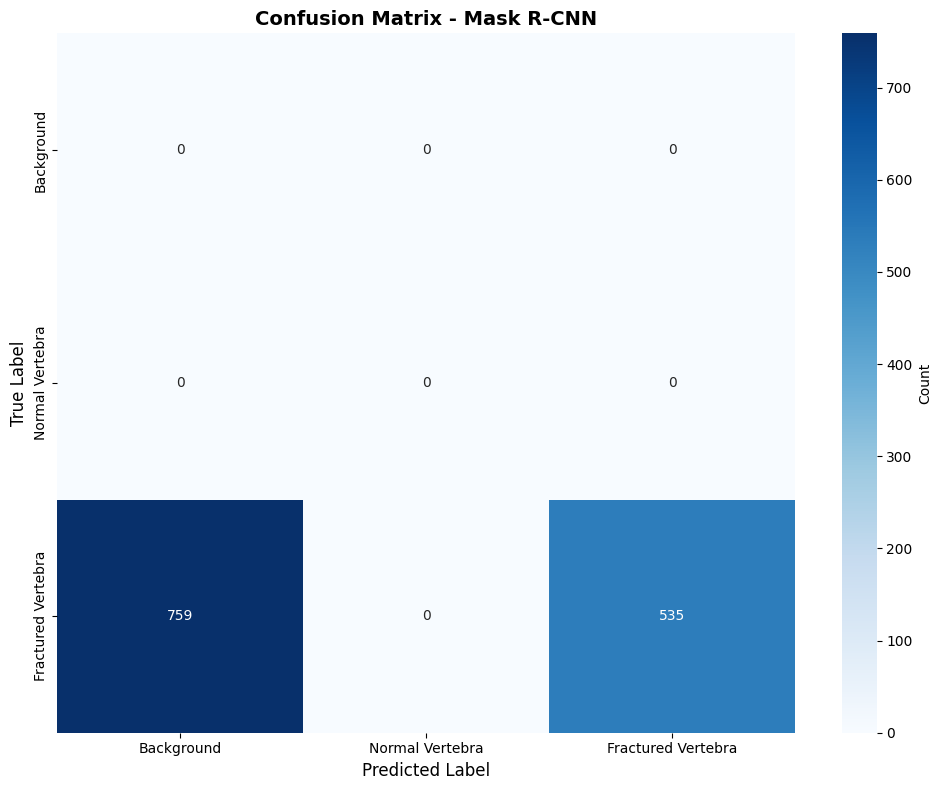


✓ Matriz de confusión guardada en 'confusion_matrix.png'

MEAN AVERAGE PRECISION (mAP)
AP@0.5 (Fractured Vertebra): 0.4134

mAP@0.5: 0.4134

📊 Generando visualizaciones...


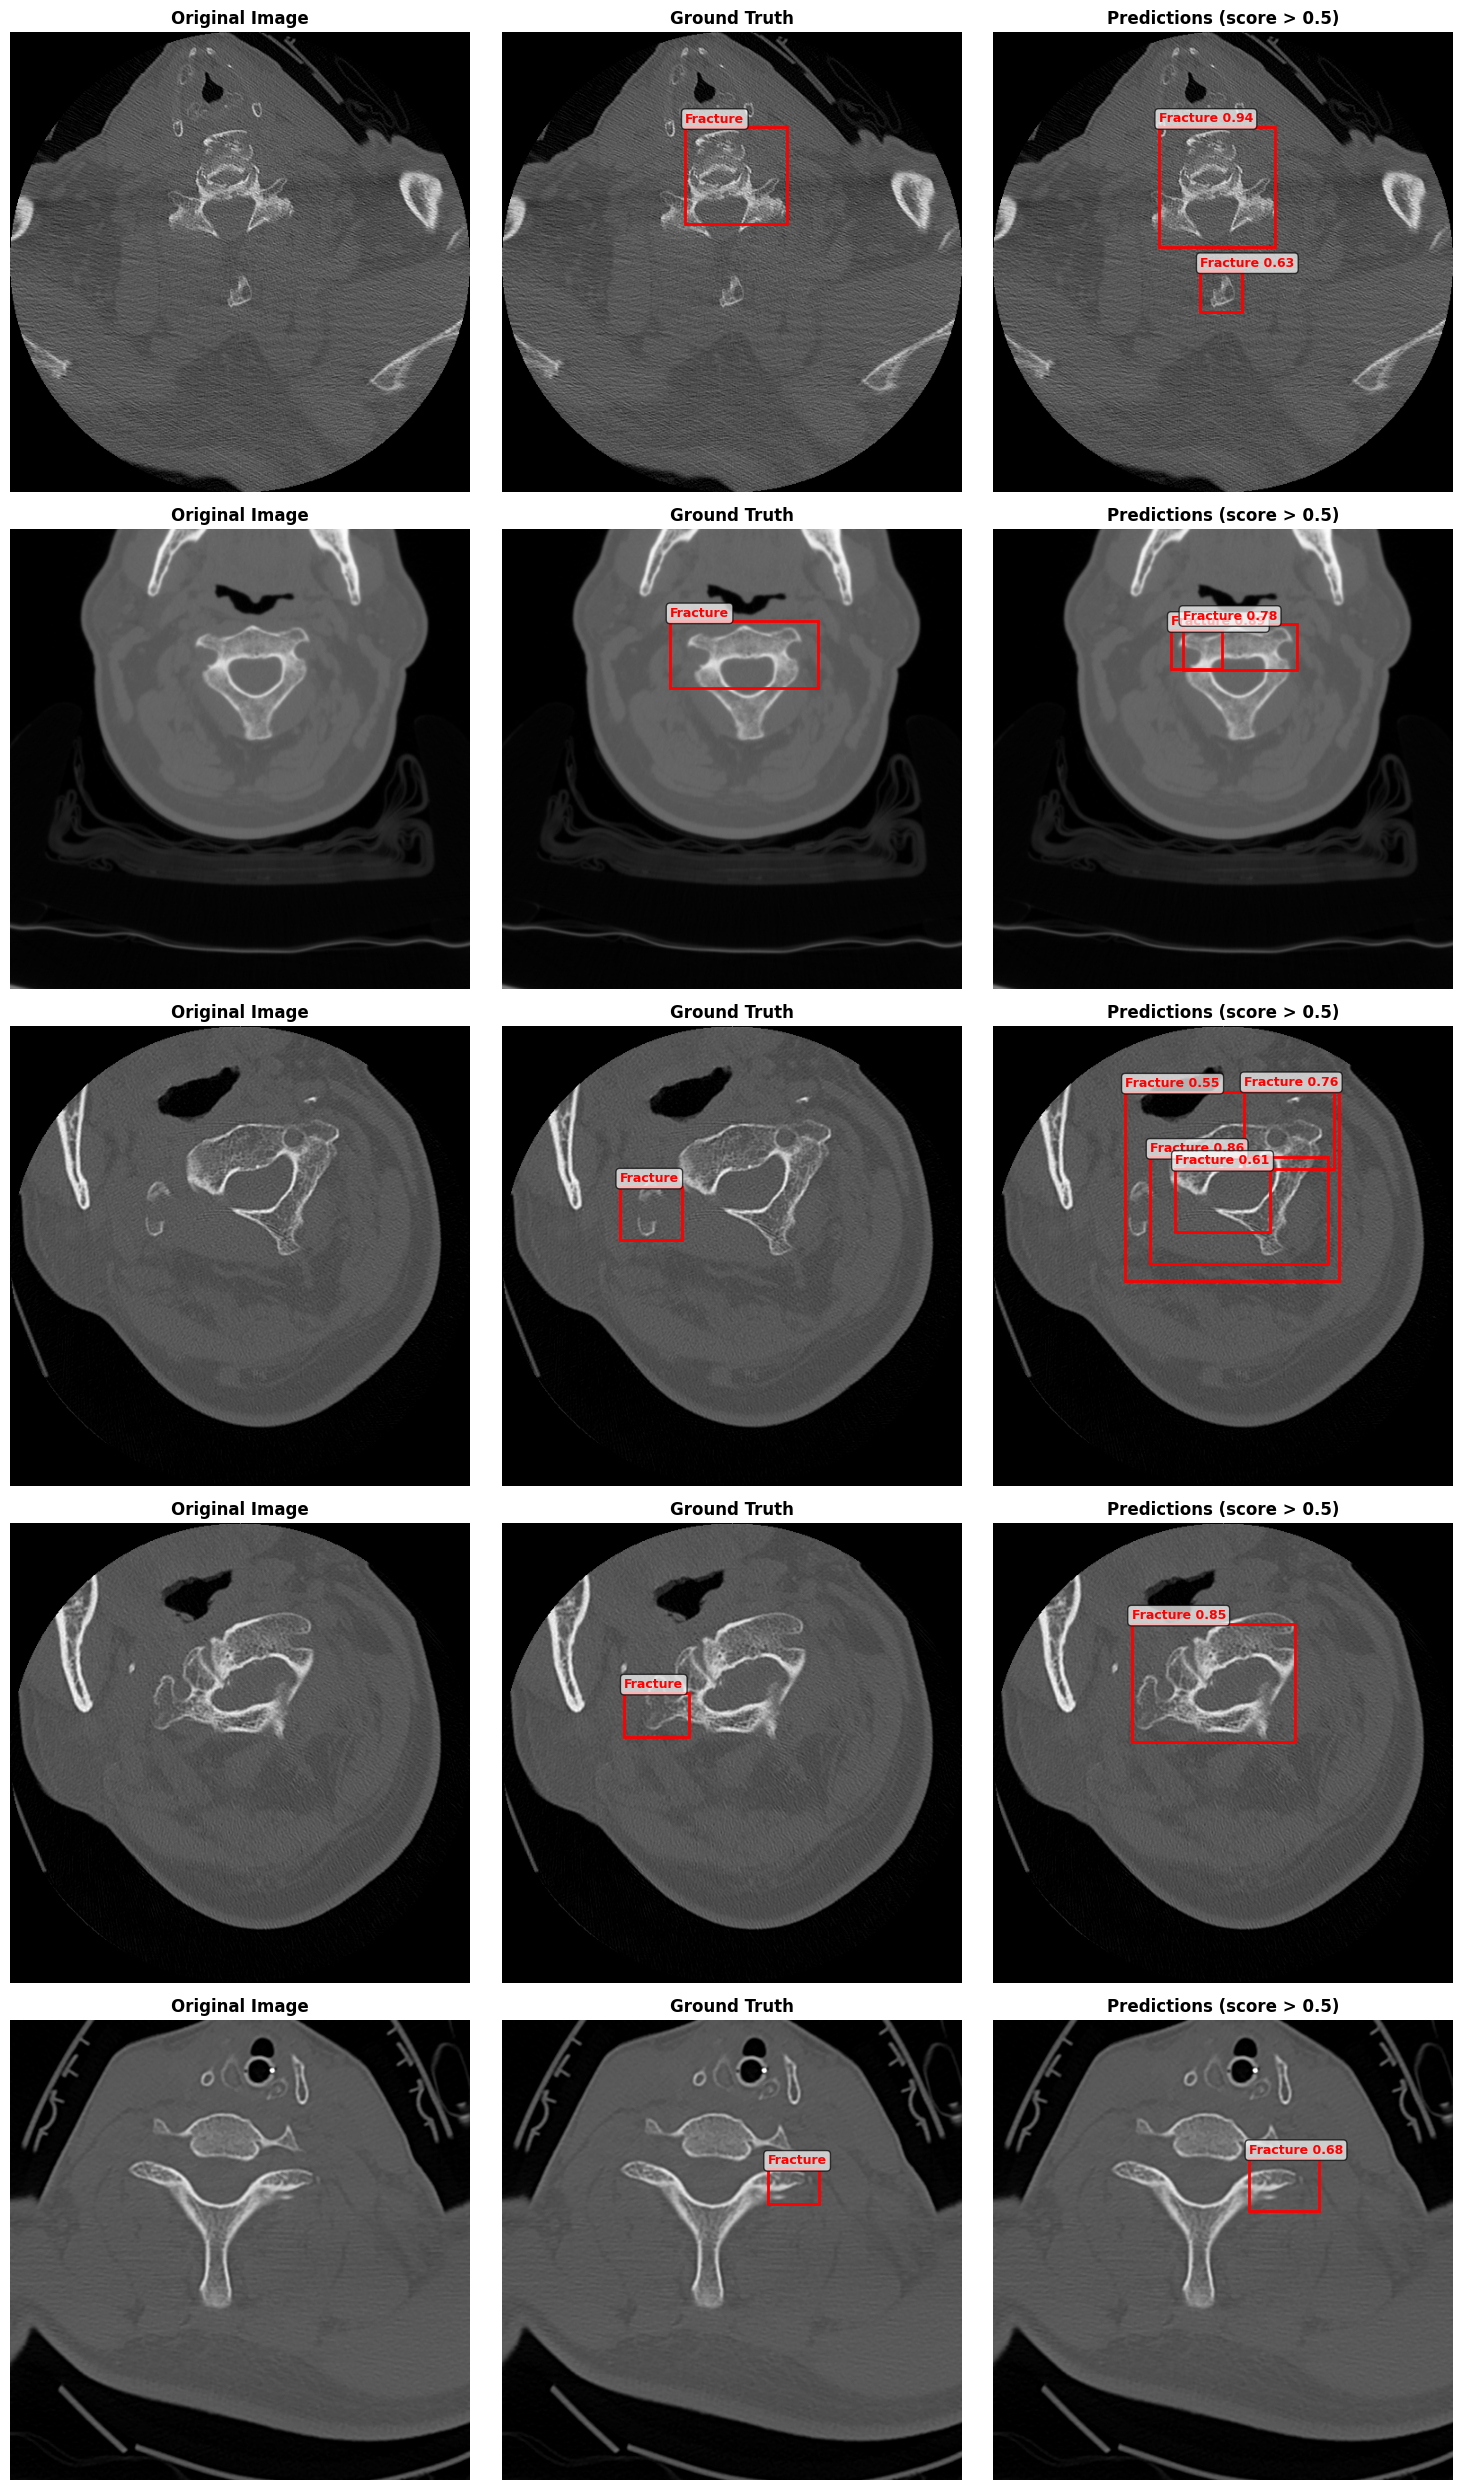


✓ Predicciones guardadas en 'test_predictions.png'

✅ EVALUACIÓN COMPLETADA
Archivos generados:
  - confusion_matrix.png
  - test_predictions.png


In [46]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# EVALUACIÓN EN TEST SET - MASK R-CNN
# ============================================================================

class TestEvaluator:
    """Evaluador completo para Mask R-CNN en test set"""
    
    def __init__(self, model, device, iou_threshold=0.5, score_threshold=0.5):
        """
        Args:
            model: Modelo Mask R-CNN entrenado
            device: cuda o cpu
            iou_threshold: Umbral de IoU para considerar detección correcta
            score_threshold: Umbral de confianza para predicciones
        """
        self.model = model
        self.device = device
        self.iou_threshold = iou_threshold
        self.score_threshold = score_threshold
        
        # Métricas acumuladas
        self.all_predictions = []
        self.all_ground_truths = []
        self.all_scores = []
        
    def compute_iou(self, box1, box2):
        """Calcula IoU (Intersection over Union) entre dos bounding boxes"""
        x1_min, y1_min, x1_max, y1_max = box1
        x2_min, y2_min, x2_max, y2_max = box2
        
        # Intersección
        inter_x_min = max(x1_min, x2_min)
        inter_y_min = max(y1_min, y2_min)
        inter_x_max = min(x1_max, x2_max)
        inter_y_max = min(y1_max, y2_max)
        
        if inter_x_max < inter_x_min or inter_y_max < inter_y_min:
            return 0.0
        
        inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
        
        # Áreas de cada box
        box1_area = (x1_max - x1_min) * (y1_max - y1_min)
        box2_area = (x2_max - x2_min) * (y2_max - y2_min)
        
        # Union
        union_area = box1_area + box2_area - inter_area
        
        iou = inter_area / (union_area + 1e-6)
        return iou
    
    def match_predictions_to_ground_truth(self, pred_boxes, pred_labels, pred_scores,
                                         gt_boxes, gt_labels):
        """
        Empareja predicciones con ground truth usando IoU
        
        Returns:
            matched_preds: Lista de labels predichos emparejados
            matched_gts: Lista de labels ground truth emparejados
            matched_scores: Scores de las predicciones emparejadas
        """
        matched_preds = []
        matched_gts = []
        matched_scores = []
        
        # Filtrar predicciones por score
        valid_indices = pred_scores >= self.score_threshold
        pred_boxes = pred_boxes[valid_indices]
        pred_labels = pred_labels[valid_indices]
        pred_scores = pred_scores[valid_indices]
        
        # Trackear qué GT boxes ya fueron emparejados
        gt_matched = [False] * len(gt_boxes)
        
        # Para cada predicción, buscar mejor match con GT
        for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores):
            best_iou = 0
            best_gt_idx = -1
            
            for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
                if gt_matched[gt_idx]:
                    continue
                
                iou = self.compute_iou(pred_box, gt_box)
                
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
            
            # Si encontramos un match válido
            if best_iou >= self.iou_threshold and best_gt_idx >= 0:
                gt_matched[best_gt_idx] = True
                matched_preds.append(pred_label)
                matched_gts.append(gt_labels[best_gt_idx])
                matched_scores.append(pred_score)
        
        # Agregar GT boxes no detectados como False Negatives
        for gt_idx, (gt_label, is_matched) in enumerate(zip(gt_labels, gt_matched)):
            if not is_matched:
                matched_preds.append(0)  # Background (no detectado)
                matched_gts.append(gt_label)
                matched_scores.append(0.0)
        
        return matched_preds, matched_gts, matched_scores
    
    @torch.no_grad()
    def evaluate_dataset(self, dataloader):
        """Evalúa el modelo en todo el dataset"""
        self.model.eval()
        
        print("\n" + "="*80)
        print("EVALUANDO MODELO EN TEST SET")
        print("="*80)
        print(f"IoU Threshold: {self.iou_threshold}")
        print(f"Score Threshold: {self.score_threshold}")
        print()
        
        for batch_idx, (images, targets) in enumerate(tqdm(dataloader, desc="Evaluating")):
            images = [img.to(self.device) for img in images]
            
            # Predicciones
            predictions = self.model(images)
            
            # Procesar cada imagen del batch
            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].cpu().numpy()
                pred_labels = pred['labels'].cpu().numpy()
                pred_scores = pred['scores'].cpu().numpy()
                
                gt_boxes = target['boxes'].cpu().numpy()
                gt_labels = target['labels'].cpu().numpy()
                
                # Emparejar predicciones con ground truth
                matched_preds, matched_gts, matched_scores = \
                    self.match_predictions_to_ground_truth(
                        pred_boxes, pred_labels, pred_scores,
                        gt_boxes, gt_labels
                    )
                
                self.all_predictions.extend(matched_preds)
                self.all_ground_truths.extend(matched_gts)
                self.all_scores.extend(matched_scores)
    
    def compute_metrics(self):
        """Calcula todas las métricas de evaluación"""
        from sklearn.metrics import (accuracy_score as acc_score, 
                                     precision_score, recall_score, f1_score)
        
        print("\n" + "="*80)
        print("MÉTRICAS DE EVALUACIÓN")
        print("="*80)
        
        y_true = np.array(self.all_ground_truths)
        y_pred = np.array(self.all_predictions)
        
        # 1. ACCURACY
        accuracy = acc_score(y_true, y_pred)
        print(f"\n📊 ACCURACY GLOBAL: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        # 2. MÉTRICAS POR CLASE
        print("\n" + "-"*80)
        print("MÉTRICAS POR CLASE")
        print("-"*80)
        
        class_names = ['Background', 'Normal Vertebra', 'Fractured Vertebra']
        precision, recall, f1, support = precision_recall_fscore_support(
            y_true, y_pred, labels=[0, 1, 2], zero_division=0
        )
        
        results_df = pd.DataFrame({
            'Class': class_names,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': support
        })
        
        print(results_df.to_string(index=False))
        
        # 3. CLASSIFICATION REPORT
        print("\n" + "-"*80)
        print("CLASSIFICATION REPORT")
        print("-"*80)
        print(classification_report(
            y_true, y_pred,
            target_names=class_names,
            labels=[0, 1, 2],
            zero_division=0
        ))
        
        # 4. MÉTRICAS PARA DETECCIÓN DE FRACTURAS (Clase 2)
        print("\n" + "="*80)
        print("MÉTRICAS ESPECÍFICAS PARA FRACTURAS (Clase 2)")
        print("="*80)
        
        # Convertir a problema binario: Fractura (2) vs No-Fractura (0, 1)
        y_true_binary = (y_true == 2).astype(int)
        y_pred_binary = (y_pred == 2).astype(int)
        
        fracture_accuracy = acc_score(y_true_binary, y_pred_binary)
        fracture_precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        fracture_recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        fracture_f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
        
        print(f"Accuracy (Fractura vs No-Fractura): {fracture_accuracy:.4f} ({fracture_accuracy*100:.2f}%)")
        print(f"Precision (Sensibilidad): {fracture_precision:.4f} ({fracture_precision*100:.2f}%)")
        print(f"Recall (Especificidad): {fracture_recall:.4f} ({fracture_recall*100:.2f}%)")
        print(f"F1-Score: {fracture_f1:.4f}")
        
        # 5. CONFUSION MATRIX
        self.plot_confusion_matrix(y_true, y_pred, class_names)
        
        # 6. mAP (mean Average Precision)
        self.compute_map()
        
        return {
            'accuracy': accuracy,
            'fracture_accuracy': fracture_accuracy,
            'precision': fracture_precision,
            'recall': fracture_recall,
            'f1_score': fracture_f1,
            'per_class_metrics': results_df
        }
    
    def plot_confusion_matrix(self, y_true, y_pred, class_names):
        """Grafica la matriz de confusión"""
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names,
                   cbar_kws={'label': 'Count'})
        plt.title('Confusion Matrix - Mask R-CNN', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n✓ Matriz de confusión guardada en 'confusion_matrix.png'")
    
    def compute_map(self):
        """Calcula mean Average Precision (mAP)"""
        print("\n" + "="*80)
        print("MEAN AVERAGE PRECISION (mAP)")
        print("="*80)
        
        # Calcular AP para cada clase (excluyendo background)
        aps = []
        
        for class_id in [1, 2]:  # Normal y Fracturada
            # Filtrar predicciones y ground truth para esta clase
            class_mask_gt = np.array(self.all_ground_truths) == class_id
            class_mask_pred = np.array(self.all_predictions) == class_id
            
            if class_mask_gt.sum() == 0:
                continue
            
            # Calcular precision para esta clase
            true_positives = (class_mask_gt & class_mask_pred).sum()
            false_positives = (~class_mask_gt & class_mask_pred).sum()
            false_negatives = (class_mask_gt & ~class_mask_pred).sum()
            
            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            
            ap = precision * recall
            aps.append(ap)
            
            class_name = 'Normal Vertebra' if class_id == 1 else 'Fractured Vertebra'
            print(f"AP@{self.iou_threshold} ({class_name}): {ap:.4f}")
        
        map_score = np.mean(aps) if aps else 0.0
        print(f"\nmAP@{self.iou_threshold}: {map_score:.4f}")
        print("="*80)
        
        return map_score
    
    def visualize_predictions(self, dataset, num_samples=5):
        """Visualiza predicciones con métricas"""
        self.model.eval()
        
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
        
        for idx, ax_row in zip(indices, axes):
            img, target = dataset[idx]
            
            with torch.no_grad():
                prediction = self.model([img.to(self.device)])[0]
            
            img_np = img.permute(1, 2, 0).cpu().numpy()
            
            # Columna 1: Imagen original
            ax_row[0].imshow(img_np)
            ax_row[0].set_title("Original Image", fontweight='bold')
            ax_row[0].axis('off')
            
            # Columna 2: Ground Truth
            ax_row[1].imshow(img_np)
            ax_row[1].set_title("Ground Truth", fontweight='bold')
            
            for box, label in zip(target['boxes'], target['labels']):
                x1, y1, x2, y2 = box.cpu().numpy()
                color = 'red' if label == 2 else 'green'
                label_text = 'Fracture' if label == 2 else 'Normal'
                
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                    linewidth=2, edgecolor=color, facecolor='none')
                ax_row[1].add_patch(rect)
                ax_row[1].text(x1, y1-5, label_text, color=color,
                             fontsize=9, weight='bold',
                             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
            ax_row[1].axis('off')
            
            # Columna 3: Predicciones
            ax_row[2].imshow(img_np)
            ax_row[2].set_title(f"Predictions (score > {self.score_threshold})", fontweight='bold')
            
            scores = prediction['scores'].cpu().numpy()
            boxes = prediction['boxes'].cpu().numpy()
            labels = prediction['labels'].cpu().numpy()
            
            for box, score, label in zip(boxes, scores, labels):
                if score > self.score_threshold:
                    x1, y1, x2, y2 = box
                    color = 'red' if label == 2 else 'blue'
                    label_text = 'Fracture' if label == 2 else 'Normal'
                    
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                       linewidth=2, edgecolor=color, facecolor='none')
                    ax_row[2].add_patch(rect)
                    ax_row[2].text(x1, y1-5, f'{label_text} {score:.2f}',
                                 color=color, fontsize=9, weight='bold',
                                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
            ax_row[2].axis('off')
        
        plt.tight_layout()
        plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n✓ Predicciones guardadas en 'test_predictions.png'")

# ============================================================================
# FUNCIÓN PRINCIPAL DE EVALUACIÓN
# ============================================================================

def evaluate_on_test(model_path='best_mask_rcnn.pth',
                    iou_threshold=0.5,
                    score_threshold=0.5):
    """
    Evalúa el modelo entrenado en el conjunto de test
    
    Args:
        model_path: Ruta al modelo guardado
        iou_threshold: Umbral IoU para matching
        score_threshold: Umbral de confianza mínima
    """
   
    
    print("\n" + "="*80)
    print("EVALUACIÓN EN TEST SET - MASK R-CNN")
    print("="*80)
    print(f"Modelo: {model_path}")
    print(f"Device: {config.DEVICE}")
    print()
    
    # 1. Cargar datos
    print("📊 Cargando datos de test...")
    train_df = pd.read_csv(config.TRAIN_CSV)
    bbox_df = pd.read_csv(config.BBOX_CSV)
    
    # Usar estudios con bboxes como test
    studies_with_bbox = bbox_df['StudyInstanceUID'].unique()
    
    # Split: usar últimos 20% como test
    from sklearn.model_selection import train_test_split
    _, test_studies = train_test_split(
        studies_with_bbox,
        test_size=0.2,
        random_state=config.RANDOM_STATE
    )
    
    print(f"   ✓ Test studies: {len(test_studies)}")
    
    # 2. Crear dataset de test
    test_dataset = CervicalSpineDataset(
        test_studies, train_df, bbox_df,
        config.TRAIN_IMG_PATH, get_valid_transforms()
    )
    
    print(f"   ✓ Test samples: {len(test_dataset)}")
    
    if len(test_dataset) == 0:
        print("❌ No hay samples de test disponibles")
        return
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        collate_fn=collate_fn
    )
    
    # 3. Cargar modelo
    print("\n🏗️  Cargando modelo...")
    model = get_model_maskrcnn(num_classes=config.NUM_CLASSES, pretrained=False)
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=config.DEVICE))
        print(f"   ✓ Modelo cargado desde '{model_path}'")
    else:
        print(f"   ❌ No se encontró el modelo en '{model_path}'")
        print("   Entrenando modelo primero...")
        return
    
    model.to(config.DEVICE)
    
    # 4. Evaluar
    evaluator = TestEvaluator(model, config.DEVICE, iou_threshold, score_threshold)
    evaluator.evaluate_dataset(test_loader)
    
    # 5. Calcular métricas
    metrics = evaluator.compute_metrics()
    
    # 6. Visualizar predicciones
    print("\n📊 Generando visualizaciones...")
    evaluator.visualize_predictions(test_dataset, num_samples=5)
    
    print("\n" + "="*80)
    print("✅ EVALUACIÓN COMPLETADA")
    print("="*80)
    print("Archivos generados:")
    print("  - confusion_matrix.png")
    print("  - test_predictions.png")
    print("="*80)
    
    return metrics

# ============================================================================
# EJECUTAR EVALUACIÓN
# ============================================================================

if __name__ == "__main__":
    # Evaluar modelo con diferentes umbrales si lo deseas
    metrics = evaluate_on_test(
        model_path='best_mask_rcnn.pth',
        iou_threshold=0.5,
        score_threshold=0.5
    )
    
    # Opcional: Probar con diferentes umbrales
    # print("\n\nProbando con score_threshold=0.7...")
    # metrics_high = evaluate_on_test(score_threshold=0.7)